In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from pathlib import Path
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
import gdown
# file_id = "15vMQxAqfESdK9lT7xalduVtR8Ypyn2rx"
# file_id = "1FZs_TECGtRJivS_Z6hHCImdwRTMQp3s5"
# file_id = "1yvAMnght_VDN54o4BLKyHS0foJZRn1Bh"
# file_id = "1XO5c7D8-_xHz4Nr3Ea42Ri5pt1koGtm1"
# file_id = "1eKcS0pYMrL4Rcvsa63v7Zdsu00kSLiyf"
file_id = "1FqPb7Aq4Jd6KQoybA2B_fH7aG30bIBN7"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1FqPb7Aq4Jd6KQoybA2B_fH7aG30bIBN7
To: /content/Dataset (4).zip
100%|██████████| 1.45G/1.45G [00:21<00:00, 68.8MB/s]


'Dataset (4).zip'

In [ ]:
# !unzip 'Dataset.zip'
# !unzip 'Dataset (2).zip'
# !unzip 'Dataset (3).zip'
!unzip 'Dataset (4).zip'

Archive:  Dataset (4).zip
replace TB_Chest_Radiography_Database/Normal.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace TB_Chest_Radiography_Database/Normal/CHNCXR_0001_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from pathlib import Path
train_dir = Path('/content/TB_Chest_Radiography_Database')

In [ ]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'Normal'
Tuberculosis_cases_dir = train_dir / 'Tuberculosis'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
Tuberculosis_cases = Tuberculosis_cases_dir.glob('*.png')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in Tuberculosis_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/TB_Chest_Radiography_Database/Normal/...,0
1,/content/TB_Chest_Radiography_Database/Normal/...,0
2,/content/TB_Chest_Radiography_Database/Normal/...,0
3,/content/TB_Chest_Radiography_Database/Normal/...,0
4,/content/TB_Chest_Radiography_Database/Normal/...,0


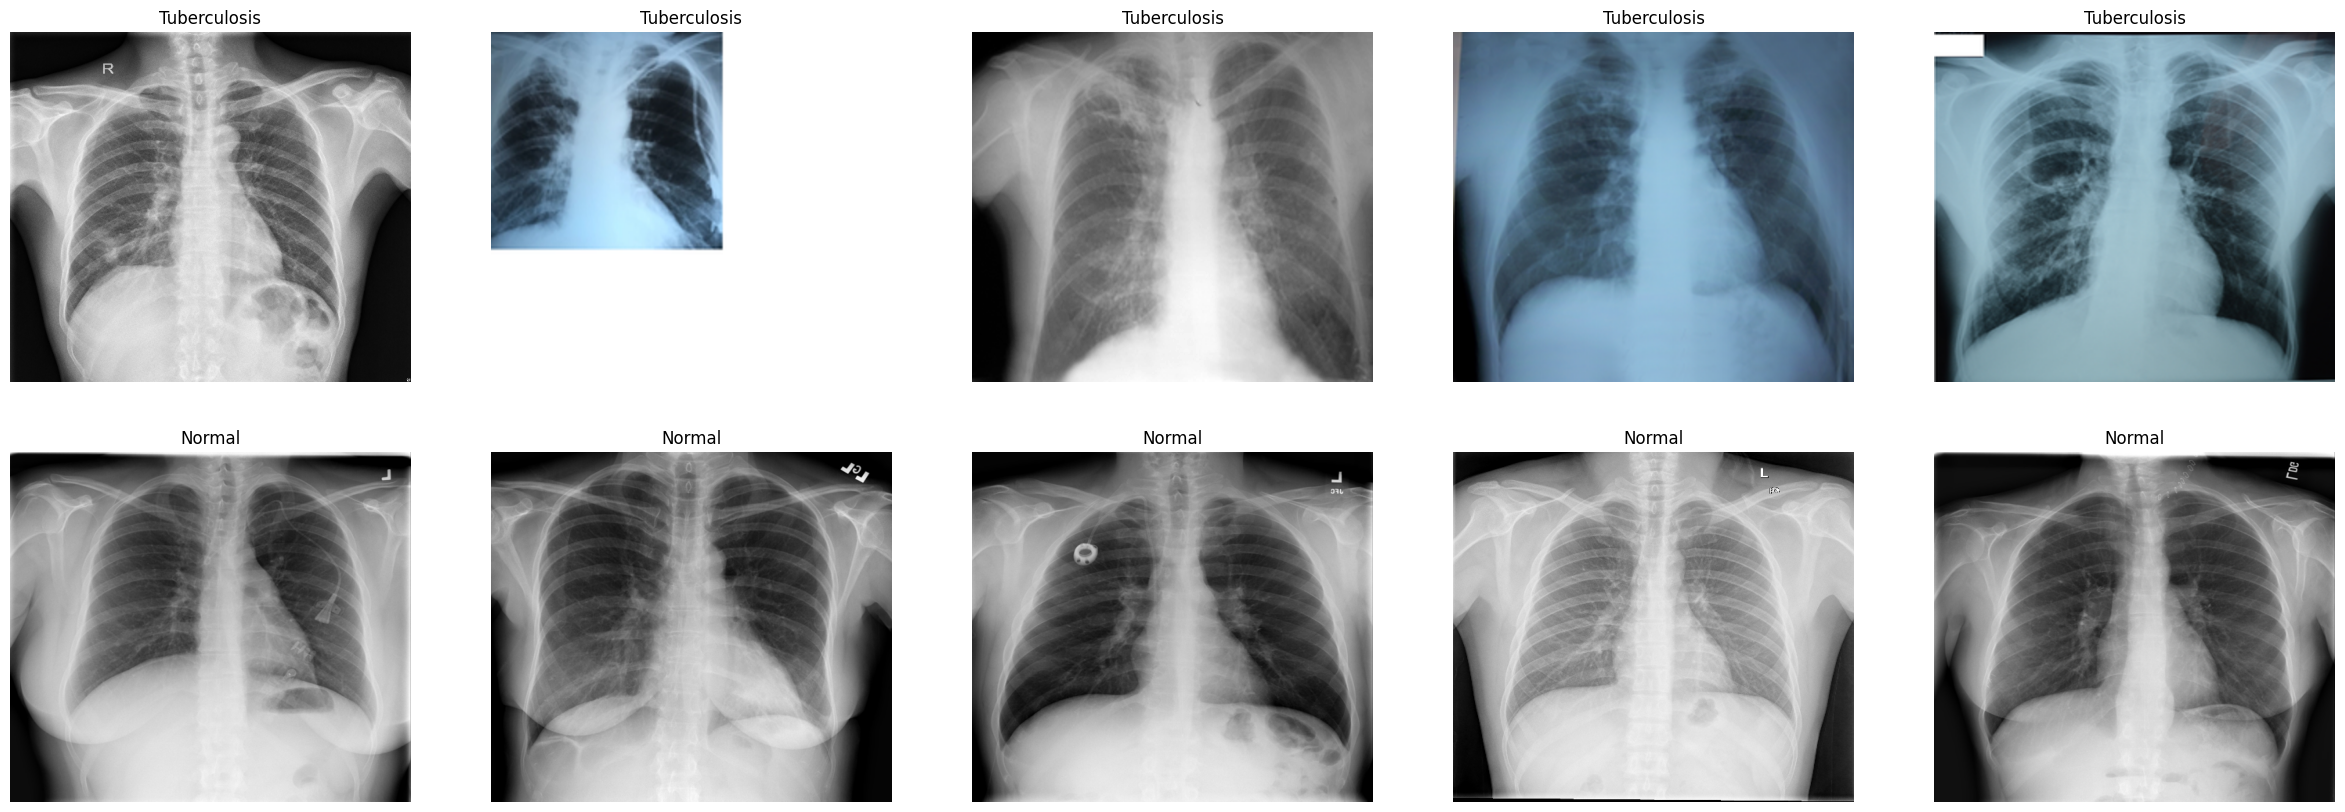

In [ ]:
# Get few samples for both the classes
Tuberculosis_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Tuberculosis_samples + normal_samples
del Tuberculosis_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Tuberculosis")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:

# Ensure GPU is used
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
def load_data(data_path, img_size=(224, 224)):
    classes = ['Normal', 'Tuberculosis']
    X = []
    y = []
    image_names = []

    for label, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label)
                image_names.append(img_name)

    X = np.array(X)
    y = np.array(y)
    return X, y, image_names

# Load your data
data_path = '/content/TB_Chest_Radiography_Database'  # Ganti dengan path ke folder data Anda, dataset 4 using TB 4906 dataset
X, y, _ = load_data(data_path)

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Augmentation for minority class (Tuberculosis)
# Changing augmentation ways, because the data test primer is croping through chest so enchant the zoom
datagen = ImageDataGenerator(
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

X_tuberculosis = X_train[y_train == 1]
y_tuberculosis = y_train[y_train == 1]

# Number of images needed for augmentation first data 3500 next data 3906
num_images_needed = 3906 - len(X_tuberculosis)
X_augmented = []
y_augmented = []

# Augmenting images to reach the desired count
for i in range(len(X_tuberculosis)):
    x = X_tuberculosis[i]
    x = x.reshape((1,) + x.shape)  # reshape for ImageDataGenerator
    for batch in datagen.flow(x, batch_size=1):
        X_augmented.append(batch[0])
        y_augmented.append(1)
        if len(X_augmented) >= num_images_needed:
            break
    if len(X_augmented) >= num_images_needed:
        break

# # Combine original and augmented data
# X_train_augmented = np.concatenate((X_train, np.array(X_augmented)))
# y_train_augmented = np.concatenate((y_train, np.array(y_augmented)))


# # Generate more samples for tuberculosis class
# X_augmented = []
# y_augmented = []

# for i in range(len(X_tuberculosis)):
#     x = X_tuberculosis[i]
#     x = x.reshape((1,) + x.shape)  # reshape for ImageDataGenerator
#     for batch in datagen.flow(x, batch_size=1):
#         X_augmented.append(batch[0])
#         y_augmented.append(1)
#         if len(X_augmented) >= 3500 - len(X_tuberculosis):
#             break
#     if len(X_augmented) >= 3500 - len(X_tuberculosis):
#         break

X_train = np.concatenate((X_train, np.array(X_augmented)))
y_train = np.concatenate((y_train, np.array(y_augmented)))

In [ ]:
# Apply SMOTE for further balancing
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train.reshape((X_train.shape[0], -1)), y_train)
X_train_res = X_train_res.reshape((-1, 224, 224, 3))  # reshape back to image format

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Load MobileNetV2 base model
input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Print model summary
model.summary()

<ipython-input-17-7f16e32d8e06>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train Model
with tf.device('/GPU:0'):
    history = model.fit(
        X_train_res, y_train_res,
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        class_weight=class_weights
    )

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8918 - loss: 0.2729 - val_accuracy: 0.9440 - val_loss: 0.1825
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9703 - loss: 0.0882 - val_accuracy: 0.9480 - val_loss: 0.1409
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9750 - loss: 0.0731 - val_accuracy: 0.9000 - val_loss: 0.2606
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9779 - loss: 0.0611 - val_accuracy: 0.9450 - val_loss: 0.1363
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9799 - loss: 0.0581 - val_accuracy: 0.9440 - val_loss: 0.1334
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.9780 - loss: 0.0561 - val_accuracy: 0.9550 - val_loss: 0.1351
Epoch 7/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9819 - loss: 0.0486 - val_accuracy: 0.9590 - val_loss: 0.1198
Epoch 8/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9829 - loss: 0.0496 - val_acc

In [ ]:
# Evaluate Model
with tf.device('/GPU:0'):
    loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Accuracy: {accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9490 - loss: 0.1456
Validation Accuracy: 0.9580000042915344


In [ ]:
# Predict and Evaluate with Confusion Matrix
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(conf_matrix)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step
Confusion Matrix
[[775  12]
 [ 30 183]]


Classification Report
              precision    recall  f1-score   support

      normal       0.96      0.98      0.97       787
tuberculosis       0.94      0.86      0.90       213

    accuracy                           0.96      1000
   macro avg       0.95      0.92      0.94      1000
weighted avg       0.96      0.96      0.96      1000



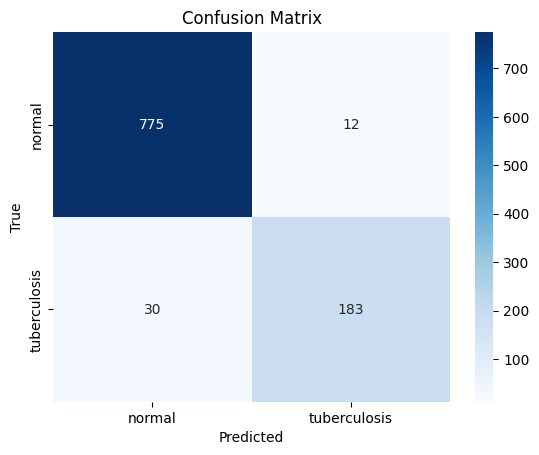

In [ ]:
# Classification report
class_report = classification_report(y_test, y_pred, target_names=['normal', 'tuberculosis'])
print('Classification Report')
print(class_report)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'tuberculosis'], yticklabels=['normal', 'tuberculosis'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def evaluate_model(conf_matrix):
  tp = conf_matrix[1][1]
  fn = conf_matrix[1][0]
  fp = conf_matrix[0][1]
  tn = conf_matrix[0][0]

  accuracy = (tp+tn)/(tp+fn+fp+tn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  specificity = tn/(tn+fp)
  f1_score = (2*precision*recall)/(precision+recall)

  return accuracy, precision, recall, specificity, f1_score

accuracy, precision, recall, specificity, f1_score = evaluate_model(conf_matrix)
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
#print("Specificity: {:.2f}".format(specificity))
print("F1-Score: {:.4f}".format(f1_score))

Accuracy: 0.9580
Precision: 0.9385
Recall: 0.8592
F1-Score: 0.8971


In [ ]:
model.save("model_TBCMN_Smote_5000_20_Zoom.h5")

In [ ]:
file_id = "1dZIED44bePAO2F8zgACEmc8O_C1fOSKG"
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id={file_id}"
)

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1dZIED44bePAO2F8zgACEmc8O_C1fOSKG
To: /content/Data Test.zip
100%|██████████| 2.47M/2.47M [00:00<00:00, 246MB/s]


'Data Test.zip'

In [ ]:
!unzip 'Data Test'

Archive:  Data Test.zip
   creating: Data Test/Normal/
  inflating: Data Test/Normal/ACHMAD IBRAHIM.JPG  
  inflating: Data Test/Normal/ADITYA WAHYU.JPG  
  inflating: Data Test/Normal/AFRIYADI.JPG  
  inflating: Data Test/Normal/AFRIYANTO.JPG  
  inflating: Data Test/Normal/AGUNG BUDI H.JPG  
  inflating: Data Test/Normal/AGUS PURNAMA.JPG  
  inflating: Data Test/Normal/AHMAD FAUZI.JPG  
  inflating: Data Test/Normal/AKHMAD Z.JPG  
  inflating: Data Test/Normal/ALI S.JPG  
  inflating: Data Test/Normal/ALI SOBRI.JPG  
  inflating: Data Test/Normal/ALI USMAN.JPG  
  inflating: Data Test/Normal/AMINAH.JPG  
  inflating: Data Test/Normal/ANWAR.JPG  
  inflating: Data Test/Normal/APRILIANTI EKA.JPG  
  inflating: Data Test/Normal/ARDIANSYAH.JPG  
  inflating: Data Test/Normal/ARIE NOLY.JPG  
  inflating: Data Test/Normal/ARISANDI.JPG  
  inflating: Data Test/Normal/ASIANA.JPG  
  inflating: Data Test/Normal/ASRI GUSLAN.JPG  
  inflating: Data Test/Normal/ASRI JUANDA.JPG  
  inflating: Dat

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 852ms/step
Image: EKO AGUS.JPG, True Label: normal, Predicted Label: normal
Image: FAREZA GIANTI.JPG, True Label: normal, Predicted Label: normal
Image: AMINAH.JPG, True Label: normal, Predicted Label: normal
Image: BUDI PRSETYA.JPG, True Label: normal, Predicted Label: normal
Image: HENDI I.JPG, True Label: normal, Predicted Label: normal
Image: AGUNG BUDI H.JPG, True Label: normal, Predicted Label: normal
Image: GREGORIUS.JPG, True Label: normal, Predicted Label: normal
Image: HALIMAH.JPG, True Label: normal, Predicted Label: normal
Image: ACHMAD IBRAHIM.JPG, True Label: normal, Predicted Label: tuberculosis
Image: AFRIYADI.JPG, True Label: normal, Predicted Label: normal
Image: IMAM S.JPG, True Label: normal, Predicted Label: normal
Image: HARDIYANTO.JPG, True Label: normal, Predicted Label: tuberculosis
Image: ASRI GUSLAN.JPG, True Label: normal, Predicted Label: tuberculosis
Image: GATOT S.JPG, True Label: normal, Predicted Label: normal
Image: DAHLAN.J

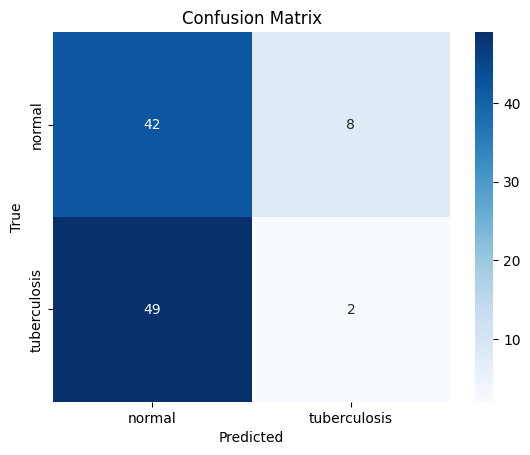

In [ ]:
# Path to your new test dataset
test_data_path = '/content/Data Test'  # Ganti dengan path ke folder data test baru Anda
X_new, y_new, image_names = load_data(test_data_path)

# Predict and evaluate new test dataset
with tf.device('/GPU:0'):
    y_pred = model.predict(X_new)
y_pred = np.round(y_pred).astype(int)

# Display predictions for each image
for i, img_name in enumerate(image_names):
    print(f"Image: {img_name}, True Label: {'normal' if y_new[i] == 0 else 'tuberculosis'}, Predicted Label: {'normal' if y_pred[i] == 0 else 'tuberculosis'}")

# Confusion matrix for new test dataset
conf_matrix = confusion_matrix(y_new, y_pred)
print('Confusion Matrix')
print(conf_matrix)

# Classification report for new test dataset
class_report = classification_report(y_new, y_pred, target_names=['normal', 'tuberculosis'])
print('Classification Report')
print(class_report)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'tuberculosis'], yticklabels=['normal', 'tuberculosis'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy, precision, recall, specificity, f1_score = evaluate_model(conf_matrix)
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
#print("Specificity: {:.2f}".format(specificity))
print("F1-Score: {:.4f}".format(f1_score))

Accuracy: 0.3366
Precision: 0.3400
Recall: 0.3333
F1-Score: 0.3366
